## Traveling Salesman Problem (TSP)

Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city exactly once and returns to the origin city?

Given a connected weighted graph, find the minimum weight Hamiltonian circuit (i.e., a cycle that visits each vertex exactly once).

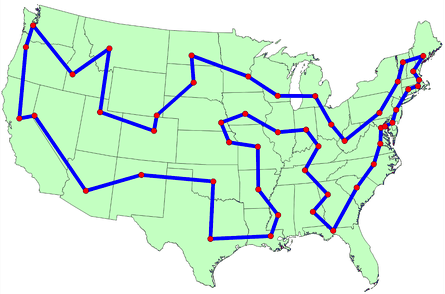

1. Generate $k$ points by creating random $x,y$ coordinates for each; the coordinates will be in the interval $[0,100]$;
2. Assume the graph $G = (V,A)$ on which to solve the TSP is _complete_, i.e. any two pairs are connected by an arc;
3. Create the optimization model for the TSP and solve it on the generated points.

In [3]:
import numpy as np
import math

k = 7  # number of nodes

grid_size = 100 # size of the grid of points

# Create k random points with two coordinates. Multiplying by grid_size yields
# random numbers between 0 and 100.
np.random.seed(1337)
point = grid_size * np.random.random((k,2))

# Define the set of vertices of the graph as the list of numbers from 0 to k-1
V = [i for i in range(k)]

# Define the set of edges of the graph as a list of pairs, one for each pair of
# nodes (i,j) in V such that i < j (to avoid duplicate edges and self loops)
E = [(i,j) for i in V for j in V if i < j]

# Determine the euclidean distance between each point
d = np.array([[math.sqrt(np.sum((point[i] - point[j])**2)) for i in V] for j in V])

Let's plot these points on the grid. We use `matplotlib` and specifically the function `matplotlib.pyplot`. We then create a complete graph and draw it on the grid.

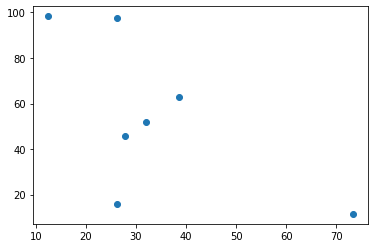

In [ ]:
import matplotlib.pyplot as plot
plot.scatter(point[:,0], point[:,1])
plot.show()

We have all data we need and proceed to create a MIP model for the TSP.

### Sets:
 * $V$ is the set of nodes
 * $E$ is the set of edges $(i,j) \in V \times V$

### Parameters:
 * $d_{ij}$ is the cost (or distance) for each $(i,j) \in E$ 

### Variables:
 * $x_{ij} \in \{0,1\}$ is equal to 1 if edge $(i,j)$ is included in the solution path, 0 otherwise

### Model

$$
\begin{array}{lll}
   \min & \sum_{(i,j) \in E} d_{ij} x_{ij}\\
   \textrm{s.t.} & \sum_{j \in V: (i,j) \in E} x_{ij} = 2 & \forall i\in V\\
                 & x_{ij} \in \{0,1\} & \forall (i,j) \in E
\end{array}
$$
In the first version of our model, we won't include any subtour-elimination constraint but will only add the first set.

In [2]:
# When using Colab, make sure you run this instruction beforehand
!pip install --upgrade cffi==1.15.0
import importlib
import cffi
importlib.reload(cffi)
!pip install mip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 427 kB 4.9 MB/s 
  Attempting uninstall: cffi
    Found existing installation: cffi 1.15.1
    Uninstalling cffi-1.15.1:
      Successfully uninstalled cffi-1.15.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.3 MB 5.3 MB/s 


In [13]:
import mip

m = mip.Model()

x = {(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in E}

for i in V:
    m.add_constr(mip.xsum(x[j,i] for j in V if j < i) +
                 mip.xsum(x[i,j] for j in V if j > i) == 2)

m.objective = mip.minimize(mip.xsum(d[i,j] * x[i,j] for (i,j) in E))
m.optimize()

print(m.objective_value)

237.01492874456386


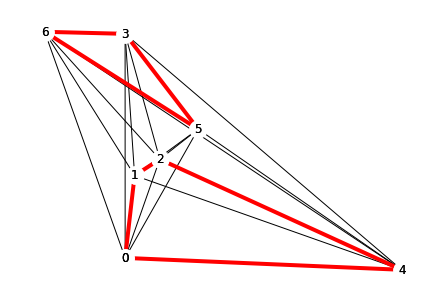

In [5]:
import networkx as nx

def draw_solution(V, A, x):
    g = nx.Graph()

    coord = {i: (point[i,0], point[i,1]) for i in V}

    # Draw the whole graph first: all nodes, all arcs, no highlighting
    g.add_nodes_from(V)
    g.add_edges_from([(i,j) for (i,j) in A])
    nx.draw(g, pos=coord, with_labels=True, node_color="white")

    # Reset the graph and add only the arcs that belong to the solution, 
    # i.e. those for which the optimal value of the variable x[i,j] is nonzero
    g.clear()
    g.add_edges_from([(i,j) for (i,j) in A if x[i,j].x > 0.5])
    nx.draw(g, pos=coord, width=4, edge_color='red', with_labels=True, node_color='white')

    # finally, draw a graph consisting of the sole root node, highlighted in green
    g.clear()
    g.add_node(0)
    nx.draw(g, pos={0: coord[0]}, node_color='white', with_labels=True)

# after defining the function, call it with the current data
draw_solution (V, E, x)

### Model

$$
\begin{array}{lll}
   \min & \sum_{(i,j) \in E} d_{ij} x_{ij}\\
   \textrm{s.t.} & \sum_{j \in V: (i,j) \in E} x_{ij} = 2 & \forall i\in V\\
                 & \sum_{(i,j) \in E: i\in C, j\in C} x_{ij} \le |C| - 1 & \forall C\subset V: C \neq \emptyset\\
                 & x_{ij} \in \{0,1\} & \forall (i,j) \in E
\end{array}
$$

We included an exponential number of subtour-elimination constraints on the previous model.

In [17]:
from itertools import chain, combinations
powerset = list(chain.from_iterable(combinations(V, r) for r in V))

247.709309381665


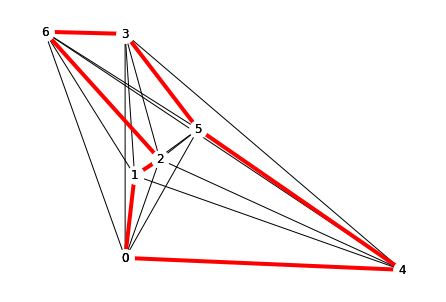

In [19]:
import mip

m = mip.Model()

x = {(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in E}

for i in V:
    m.add_constr(mip.xsum(x[j,i] for j in V if j < i) +
                 mip.xsum(x[i,j] for j in V if j > i) == 2)
    
for C in powerset:
    if len(C) > 0 and len(C) < k:
        edges_vars = [x[i,j] for (i,j) in E if i in C and j in C]
        m.add_constr(mip.xsum(edges_vars) <= len(C) - 1)

m.objective = mip.minimize(mip.xsum(d[i,j] * x[i,j] for (i,j) in E))
m.optimize()

print(m.objective_value)
draw_solution (V, E, x)

### Problem: how many constraints are needed?

Need to use $2^k$ constraints (one for each subset of $V$, given that $|V| = k$). This model is not usable in practice.

However, you can start with the model without the subtour-elimination constraints and add them only when needed.

237.01492874456386


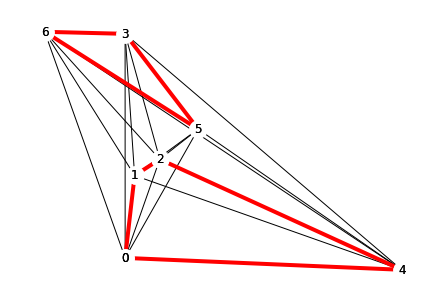

In [20]:
import mip

m = mip.Model()

x = {(i,j): m.add_var(var_type=mip.BINARY) for (i,j) in E}

for i in V:
    m.add_constr(mip.xsum(x[j,i] for j in V if j < i) +
                 mip.xsum(x[i,j] for j in V if j > i) == 2)

m.objective = mip.minimize(mip.xsum(d[i,j] * x[i,j] for (i,j) in E))
m.optimize()

print(m.objective_value)
draw_solution (V, E, x)

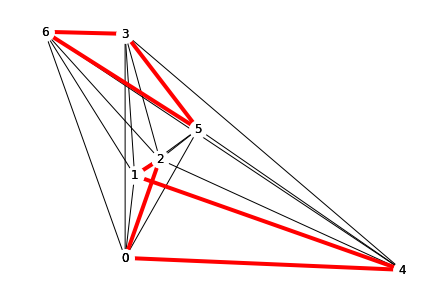

In [21]:
m.add_constr(x[0,4] + x[2,4] + x[1,2] + x[0,1] <= 3)
m.optimize()
draw_solution (V, E, x)

This is not sufficient. Need to add another constraint.

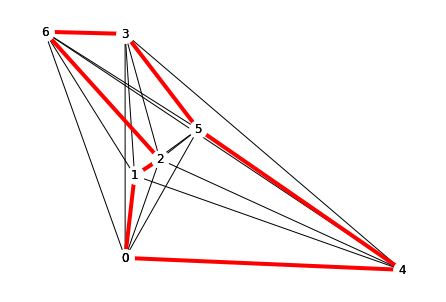

In [22]:
m.add_constr(x[3,5] + x[5,6] + x[3,6] <= 2)
m.optimize()
draw_solution (V, E, x)

How do we make this automatic? I.e. how do we repeat this step by adding the appropriate subtour-elimination constraint until we find a Hamiltonian circuit?

In [49]:
def get_cycles(V, E, x):
  graph = [[] for i in V]

  for (i,j) in E:
    if x[i,j].x > 0.5:
      graph[i].append(j)
      graph[j].append(i)

  cycles = []
  color = [0 for i in V]
  par = [-1 for i in V]

  for i in V:
    if par[i] == -1:
      dfs_cycle(graph, cycles, i, -1, color, par)

  return [c for c in cycles if len(c) < len(V) and len(c) > 0]

def dfs_cycle(graph, cycles, u, p, color, par):
    # skil completely visited vertex.
    if color[u] == 2:
        return
 
    # If vertex has been seen but not completely visited -> cycle detected.
    # Backtrack based on parents to find the complete cycle.
    if color[u] == 1:
        v = []
        cur = p
        v.append(cur)
 
        # backtrack the vertex which are
        # in the current cycle thats found
        while cur != u:
            cur = par[cur]
            v.append(cur)
        
        cycles.append(v)
        return
 
    par[u] = p
 
    # partially visited.
    color[u] = 1
 
    # simple dfs on graph
    for v in graph[u]:
        # if it has not been visited previously
        if v == par[u]:
            continue
        dfs_cycle(graph, cycles, v, u, color, par)
 
    # completely visited.
    color[u] = 2

Added constr:
constr(7): +1.0 x35 +1.0 x36 +1.0 x56 <= 2.0
247.709309381665


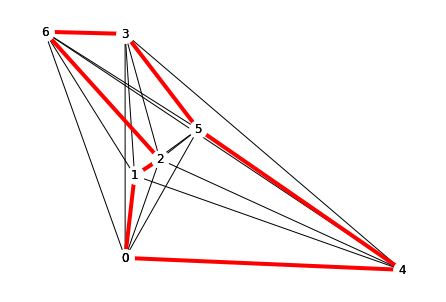

In [54]:
import mip


m = mip.Model()

x = {(i,j): m.add_var(var_type=mip.BINARY, name="x{}{}".format(str(i), str(j))) for (i,j) in E}

for i in V:
    m.add_constr(mip.xsum(x[j,i] for j in V if j < i) +
                 mip.xsum(x[i,j] for j in V if j > i) == 2)

m.objective = mip.minimize(mip.xsum(d[i,j] * x[i,j] for (i,j) in E))
m.optimize()

cycles = get_cycles(V, E, x)
while len(cycles) > 0:
  cycle = cycles.pop()
  cycle_edges = [x[i,j] for (i,j) in E if i in cycle and j in cycle]
  c = m.add_constr(mip.xsum(cycle_edges) <= len(cycle_edges) - 1)
  print("Added constr:")
  print(c)
  m.optimize()
  cycles = get_cycles(V, E, x)

print(m.objective_value)
draw_solution (V, E, x)